In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [2]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence


In [3]:
import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, r2_score, classification_report

import math

from rfpimp import *

from collections import defaultdict

In [4]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/master_df_20200206.xlsx"
data = pd.read_excel(file)
df_master = pd.DataFrame(data).set_index('FIPS')

In [5]:
print(df_master.columns)

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')


In [6]:
df_master.describe()

,PropSFHA,AveDepth,PropDG,MaxDepth,AveLS,HurTrack,PeakGust,MaxSusta,SpecCom,STRVI_1,...,R_I_NOO,R_I_NO0_NO,CAT_3Q,CAT_4Q,Ex_Q4_c,COUNT__Y,R_DES,R_AFF,log_R_IND,log_R_I_NO0
count,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,...,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,775.000000
mean,0.173662,0.982619,0.058447,2.634887,1.104161,0.223594,52.697914,41.591950,0.033937,0.000533,...,0.025018,0.025974,1.000000,1.498866,0.250567,1702.182540,0.002117,0.029921,-3.347153,-3.809275
std,0.260877,1.529905,0.159692,4.692369,0.412690,0.126709,8.664104,6.932878,0.090211,3.766862,...,0.024439,0.025482,0.814176,1.111542,0.433585,935.425845,0.006613,0.032875,1.637369,1.135331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,19.220000,0.000000,-13.150000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,-8.359135,-8.359135
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.130000,45.150000,35.320000,0.000000,-2.635000,...,0.003780,0.004243,0.000000,1.000000,0.000000,995.250000,0.000000,0.006323,-4.308255,-4.424949
50%,0.040000,0.000000,0.000000,0.000000,1.000000,0.220000,55.880000,44.260000,0.003223,-0.190000,...,0.018710,0.019184,1.000000,1.000000,0.000000,1530.500000,0.000308,0.021126,-3.475630,-3.623924
75%,0.220000,1.760000,0.020000,4.502500,1.290000,0.290000,59.900000,47.390000,0.023284,2.417500,...,0.037674,0.038911,2.000000,2.000000,0.750000,2293.000000,0.001963,0.041932,-2.687743,-3.021554
max,1.000000,9.730000,1.000000,61.940000,3.000000,0.920000,65.710000,54.540000,0.977416,16.520000,...,0.102301,0.106887,2.000000,3.000000,1.000000,7069.000000,0.142857,0.360825,0.000000,-1.019363


In [7]:
# df_master

In [8]:
def choose_data(df_master, feature_list, target_list):
    choices = feature_list + target_list
    df = df_master[choices].copy()
    df.dropna(inplace = True)
    return df

In [9]:
# # EXAMPLE:
# feature_list = ['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
#                'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1','SOVI_1', 
#                'CDC_Tot']
# target_list = ['R_IND', 'R_I_NO0']

# df = choose_data(df_master, feature_list, target_list)

In [10]:
def partition_data(df, target_str):
    y = df[target_str]
    df_x = df.drop(target_str, axis = 1)
    return y, df_x

In [11]:
# # EXAMPLE:
# target_str = 'R_IND'
# y, df_x = partition_data(df, target_str)

In [12]:
def bin_target(y, n_bins, label):
    y_binned = pd.qcut(y, q=n_bins, labels = label)
    return y_binned

In [13]:
# # EXAMPLE:
# y_binned = bin_target(y,4, [0,1,2,3])

In [14]:
def split_the_data(df_x, y):
    x_train, x_test, y_train, y_test = train_test_split(df_x, y, 
                                                        test_size=0.3, 
                                                        random_state=42,
                                                        stratify = y_binned)
    return x_train, x_test, y_train, y_test

In [15]:
# # Careful of Random State
# # Change y_binned to y if categorical
# # EXAMPLE:
# x_train, x_test, y_train, y_test = split_the_data(df_x, y)

### Import the train/test data

In [16]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/train_set_20200206.xlsx"
data = pd.read_excel(file)
train_set = pd.DataFrame(data).set_index('FIPS')

In [17]:
file = "/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/test_set_20200206.xlsx"
data = pd.read_excel(file)
test_set = pd.DataFrame(data).set_index('FIPS')

In [18]:
# train_set.drop(columns= ['STRVI_1', 'SEVI_1'], inplace=True)
# test_set.drop(columns= ['STRVI_1', 'SEVI_1'], inplace=True)

### If want to drop the extreme outlier

In [19]:
# Get names of indexes for which column Age has value 30
indexNames = train_set[train_set.y_train > 0.25].index
 
# Delete these row indexes from dataFrame
train_set.drop(indexNames , inplace=True)
train_set.describe()

,PropSFHA,AveDepth,PropDG,AveLS,HurTrack,PeakGust,SpecCom,STRVI_1,SEVI_1,CDC_Tot,y_train
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,0.181335,0.960526,0.054560,1.087344,0.220185,52.909418,0.036031,0.003409,0.118509,0.504580,0.031913
std,0.267295,1.542826,0.151175,0.405950,0.126972,8.650195,0.094485,3.821421,5.474224,0.288451,0.034157
min,0.000000,0.000000,0.000000,0.000000,0.000000,24.590000,0.000000,-13.150000,-23.740000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.130000,45.600000,0.000000,-2.665000,-2.875000,0.260200,0.006865
50%,0.045000,0.000000,0.000000,1.000000,0.220000,56.330000,0.003629,-0.150000,0.710000,0.502250,0.021963
75%,0.242500,1.700000,0.020000,1.250000,0.290000,60.350000,0.024581,2.430000,3.832500,0.757075,0.044422
max,1.000000,9.730000,1.000000,3.000000,0.920000,65.710000,0.977416,16.520000,14.060000,1.000000,0.229145


### If want to join to grab another index

In [18]:
# test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')
# train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')

In [21]:
train_set.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot', 'y_train'],
      dtype='object')

In [22]:
df_master.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
       'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
       'SOVI_1', 'STRVI_2', 'SEVI_2', 'SOVI_2', 'CDC_T1', 'CDC_T2', 'CDC_T3',
       'CDC_T4', 'CDC_Tot', 'O_IND', 'R_IND', 'R_I_NO0', 'R_I_NOO',
       'R_I_NO0_NO', 'CAT_3Q', 'CAT_4Q', 'Ex_Q4_c', 'COUNT__Y', 'R_DES',
       'R_AFF', 'log_R_IND', 'log_R_I_NO0'],
      dtype='object')

In [20]:
def new_index(df_master, train_set, test_set, Target, feature_list):
    test_set = test_set.merge(df_master, right_index=True, left_index=True, how='left')
    train_set=train_set.merge(df_master, right_index=True, left_index=True, how='left')
    
    target_list=[Target]
    test_set = choose_data(test_set, feature_list, target_list)
    train_set = choose_data(train_set, feature_list, target_list)
    
    train_set = train_set[train_set[Target] != 0]
    test_set = test_set[test_set[Target] != 0]
    
    train_set = train_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", Target:Target})
    test_set = test_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
                        "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
                        "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
                        "CDC_Tot_y": "CDC_Tot", Target:Target})
    
    return train_set, test_set


In [21]:
Target = 'R_IND'
feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
               'PeakGust_y', 'SpecCom_y','CDC_Tot_y']


train_set, test_set = new_index(df_master, train_set, test_set, Target, feature_list)

In [22]:
# # EXAMPLE:
# feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
#                'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
# target_list = ['R_I_NO0']

# test_set = choose_data(test_set, feature_list, target_list)

In [23]:
# # EXAMPLE:
# feature_list = ['PropSFHA_y', 'AveDepth_y', 'PropDG_y', 'AveLS_y', 'HurTrack_y',
#                'PeakGust_y', 'SpecCom_y', 'STRVI_1_y', 'SEVI_1_y','CDC_Tot_y']
# target_list = ['R_I_NO0']

# train_set = choose_data(train_set, feature_list, target_list)

In [24]:
# train_set.columns

In [25]:
# train_set = train_set[train_set['R_I_NO0'] != 0]
# test_set = test_set[test_set['R_I_NO0'] != 0]

In [26]:
# train_set = train_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
#                         "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
#                         "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
#                         "CDC_Tot_y": "CDC_Tot", "R_I_NO0":"R_I_NO0"})

In [27]:
# test_set = test_set.rename(columns={"PropSFHA_y": "PropSFHA", "AveDepth_y": "AveDepth", "PropDG_y":"PropDG",
#                         "AveLS_y": "AveLS", "HurTrack_y": "HurTrack", "PeakGust_y":"PeakGust",
#                         "SpecCom_y": "SpecCom", "STRVI_1_y": "STRVI_1", "SEVI_1_y":"SEVI_1",
#                         "CDC_Tot_y": "CDC_Tot", "R_I_NO0":"R_I_NO0"})

### Partition Data

In [28]:
target_str = 'R_IND'
y_train, x_train = partition_data(train_set, target_str)

target_str = 'R_IND'
y_test, x_test = partition_data(test_set, target_str)

In [30]:
y_test.describe()

count    151.000000
mean       0.035957
std        0.031779
min        0.000820
25%        0.012642
50%        0.025959
75%        0.047600
max        0.197384
Name: R_IND, dtype: float64

### Tune

In [24]:
# #Choose all predictors except target & IDcols
# # predictors = [x for x in x_train]
# mega_param_test = {'n_estimators':range(100,600,50), 'max_depth':range(10,16,2), 'min_samples_split':range(10,20,2),
#                   'min_samples_leaf':range(2,10,2), 'max_features':range(1,5,1), 'subsample':[0.75,0.8,0.85,0.9, 0.95]}
# mega_gsearch = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
#                                                               random_state=42,
#                                                               learning_rate=0.1), 
#                                                               param_grid = mega_param_test, n_jobs=4,iid=False,cv=3,verbose=2)

# mega_gsearch.fit(x_train,y_train)

# mega_gsearch.cv_results_, mega_gsearch.best_params_, mega_gsearch.best_score_

In [1]:
mega_gsearch.best_params_

NameError: name 'mega_gsearch' is not defined

In [81]:
mega_gsearch.best_score_

0.1930993661754771

In [30]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(20,201,5)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.1, 
                                                              min_samples_split=2,
                                                              min_samples_leaf=1,
                                                              max_depth=5,
                                                              max_features='auto',
                                                              subsample=0.9,
                                                              random_state=42), 
                                                              param_grid = param_test1, n_jobs=4,iid=False, cv=5)

gsearch1.fit(x_train,y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 0.07661042,  0.08005004,  0.08405552,  0.09414177,  0.10935202,
          0.1226634 ,  0.13840251,  0.1527792 ,  0.14954333,  0.16350999,
          0.17623997,  0.19820371,  0.20482278,  0.21375194,  0.22238398,
          0.25059505,  0.28244262,  0.27045941,  0.27894611,  0.27770486,
          0.3301806 ,  0.33867598,  0.31117334,  0.34234724,  0.36601429,
          0.39987974,  0.40157447,  0.3920074 ,  0.40586324,  0.43437018,
          0.43567562,  0.46188374,  0.47280993,  0.47838502,  0.52012725,
          0.52647171,  0.5057724 ]),
  'std_fit_time': array([ 0.00435247,  0.0091755 ,  0.00307137,  0.0026611 ,  0.00343182,
          0.00365673,  0.01256329,  0.00421307,  0.00440808,  0.00769877,
          0.00722964,  0.0029615 ,  0.00652495,  0.00904085,  0.00986805,
          0.00625077,  0.01330263,  0.01497414,  0.0113988 ,  0.01274015,
          0.04282412,  0.05203657,  0.01330903,  0.0074339 ,  0.0151245 ,
          0.02502903,  0.03769797,  0.0093

In [234]:
param_test2 = {'max_depth':range(2,16,1), 'min_samples_split':range(2,20,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=75, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2,n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 12, 'min_samples_split': 4}, 0.22696022955944456)

In [235]:
param_test3 = {'min_samples_split':range(2,20,1), 'min_samples_leaf':range(2,20,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=75,
                                                              max_depth=12,
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test3,n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train, y_train)

#gsearch3.cv_results_, 
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 2, 'min_samples_split': 19}, 0.22445573251038486)

In [236]:
param_test4 = {'max_features':range(1,9,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=75,
                                                               max_depth=12, 
                                                               min_samples_split=19, 
                                                               min_samples_leaf=2, 
                                                               subsample=0.8, 
                                                               random_state=42),
param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train, y_train)
#gsearch4.cv_results_, 
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 3}, 0.22445573251038486)

In [237]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                               n_estimators=75,
                                                               max_depth=12, 
                                                               min_samples_split=19, 
                                                               min_samples_leaf=2, 
                                                               #subsample=0.8, 
                                                               random_state=42,
                                                               max_features=3),
param_grid = param_test5, n_jobs=4,iid=False, cv=5)
tuned1 = gsearch5.fit(x_train, y_train)
#gsearch5.cv_results_, 
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.22445573251038486)

In [238]:
# predictors = [x for x in x_train]
gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=75,
                                        max_depth=12, 
                                        min_samples_split=19, 
                                        min_samples_leaf=2, 
                                        subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
tuned2 = gbm_tuned_1.fit(x_train, y_train)
tuned2.score(x_train, y_train)
tuned2.score(x_test, y_test)

0.26871455750387196

In [193]:
tuned2.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='lad', max_depth=12,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=19,
                          min_weight_fraction_leaf=0.0, n_estimators=70,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)>

### Plot Optimization

### Tree

In [147]:
#Choose all predictors except target & IDcols
# predictors = [x for x in x_train]
param_test1 = {'n_estimators':range(5,76,5)}
treeplot = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                             learning_rate=0.08, 
                                                              min_samples_split=16,
                                                              min_samples_leaf=4,
                                                              max_depth=12,
                                                              max_features=5,
                                                              subsample=0.8,
                                                              random_state=42), 
param_grid = param_test1,scoring='r2', n_jobs=4,iid=False, cv=5)

treeplot.fit(x_train,y_train)

treeplot.cv_results_, treeplot.best_params_, treeplot.best_score_

({'mean_fit_time': array([ 0.02369499,  0.05101633,  0.08187346,  0.10121627,  0.12935996,
          0.14931178,  0.23492579,  0.27865567,  0.23436689,  0.27995334,
          0.3191401 ,  0.45553236,  0.37139101,  0.41690416,  0.42125001]),
  'std_fit_time': array([ 0.00049394,  0.00197457,  0.00598083,  0.00403006,  0.00497967,
          0.0079646 ,  0.01936861,  0.03126948,  0.00539532,  0.02237629,
          0.03552229,  0.02467877,  0.0275129 ,  0.01908517,  0.02432636]),
  'mean_score_time': array([ 0.00109406,  0.0012187 ,  0.00127654,  0.00132394,  0.00151234,
          0.00143857,  0.00186396,  0.00175076,  0.00139723,  0.00204549,
          0.00224876,  0.00178299,  0.00191355,  0.00206041,  0.00198922]),
  'std_score_time': array([ 0.00023061,  0.00025545,  0.00019252,  0.00015374,  0.0002698 ,
          0.00019475,  0.00019871,  0.00043647,  0.00023699,  0.00072349,
          0.00016845,  0.0004517 ,  0.000411  ,  0.00037927,  0.00049898]),
  'param_n_estimators': masked_arr

In [148]:
score = pd.DataFrame(treeplot.cv_results_)

In [149]:
score['n_tree'] = range(5,76,5)

In [150]:
score.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_n_estimators', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'n_tree'],
      dtype='object')

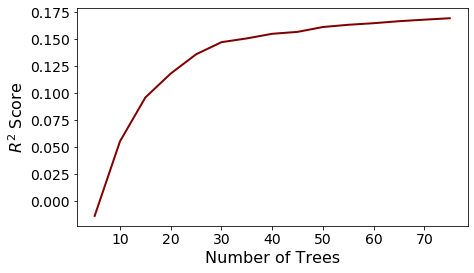

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 2, color='maroon')
ax.set_title('', fontsize=20)
#ax.grid(True)

ax.set_xlabel('Number of Trees', fontsize=16)
ax.set_ylabel(r'$R^2$' + ' Score', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.savefig('Tree_optimization_r2_2.png', dpi=600, bbox_inches = "tight")

In [69]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

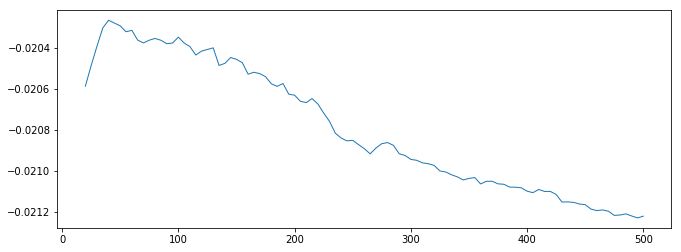

In [31]:
score = pd.DataFrame(treeplot.cv_results_)
score['n_tree'] = range(20,501,5)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['n_tree'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

### Depth

In [33]:
param_test2 = {'max_depth':range(2,50,1)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(loss = 'lad',
                                                              learning_rate=0.1, 
                                                              n_estimators=100, 
                                                              max_features='sqrt', 
                                                              subsample=0.8, 
                                                              random_state=42), 
param_grid = param_test2, n_jobs=4,iid=False, cv=5)

gsearch2.fit(x_train,y_train)

gsearch2.cv_results_, 
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 14}, 0.23956849825819013)

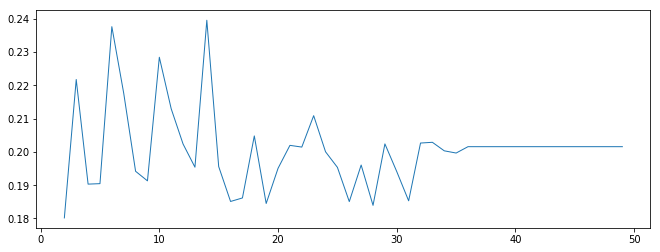

In [34]:
score = pd.DataFrame(gsearch2.cv_results_)
score['depth'] = range(2,50,1)


fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(score['depth'], score['mean_test_score'], linewidth = 1)
# ax.set_title('Non-Tidal Component by FFT - Chesapeake Bay Bridge Tunnel', fontsize=20)
# #ax.set_xlabel('Date', fontsize=16)
# ax.set_ylabel('Water Elevation (m)', fontsize=16)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)

# Optimization Results

In [31]:
# IDEAL1 (SCORE 70%/15%)

gbrt = GradientBoostingRegressor(loss = 'ls',
                                #alpha = .4,
                                learning_rate = 0.05,
                                n_estimators=175,
                                subsample = 0.78,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 11,
                                random_state = 42,
                                max_depth = 6,
                                max_features = 1)
IDEAL1 = gbrt.fit(x_train, y_train)

print(IDEAL1.score(x_test, y_test))
print(IDEAL1.score(x_train, y_train))

0.198255017519
0.721742138841


In [32]:
#IDEAL2 (SCORE 80%/ 16%)

gbrt = GradientBoostingRegressor(loss = 'lad',
                                #alpha = .4,
                                learning_rate = 0.1,
                                n_estimators=500,
                                subsample = 0.9,
                                criterion = "friedman_mse",
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                random_state = 42,
                                max_depth = 5,
                                max_features = 'auto')
IDEAL2 = gbrt.fit(x_train, y_train)

print(IDEAL2.score(x_test, y_test))
print(IDEAL2.score(x_train, y_train))

0.243663257053
0.74767404271


In [33]:
# IDEAL3A (SCORE 57%/13%)

gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=140,
                                        max_depth=12, 
                                        min_samples_split=19, 
                                        min_samples_leaf=9, 
                                        subsample=0.8, 
                                        random_state=42,
                                        max_features=3)
IDEAL3A = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL3A.score(x_test, y_test))
print(IDEAL3A.score(x_train, y_train))

0.314986221928
0.578632509583


In [34]:
# IDEAL 3 (SCORE 82%/35%) -- R_IND_NOOUTLIER

gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.05, 
                                        n_estimators=500,
                                        max_depth=12, 
                                        min_samples_split=19,
                                        min_samples_leaf=3, 
                                        subsample=0.9, 
                                        random_state=42,
                                        max_features=3)
IDEAL3 = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL3.score(x_test, y_test))
print(IDEAL3.score(x_train, y_train))

0.307185393879
0.78810178668


In [31]:
# IDEAL 3B (SCORE 82%/35%) -- R_IND_NOOUTLIER

gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.09, 
                                        n_estimators=500,
                                        max_depth=11, 
                                        min_samples_split=15,
                                        min_samples_leaf=3, 
                                        subsample=0.9, 
                                        random_state=42,
                                        max_features=3)
IDEAL3B = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL3B.score(x_test, y_test))
print(IDEAL3B.score(x_train, y_train))

0.333963857265
0.85972811046


### R_IND

In [36]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=95,
                                subsample = 0.8,
                                random_state=42)

IDEAL4 = gbrt.fit(x_train, y_train)

print(IDEAL4.score(x_test, y_test))
print(IDEAL4.score(x_train, y_train))


0.363002750844
0.686059940664


In [37]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=102,
                                subsample = 0.8,
                                random_state=42)

IDEAL4AA = gbrt.fit(x_train, y_train)

print(IDEAL4AA.score(x_test, y_test))
print(IDEAL4AA.score(x_train, y_train))

0.364056593428
0.69966010889


In [38]:
# Results from optimization, switch up learning rate and see

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=4,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=108,
                                subsample = 0.74,
                                random_state=42)
                                         

IDEAL4A = gbrt.fit(x_train, y_train)

print(IDEAL4A.score(x_test, y_test))
print(IDEAL4A.score(x_train, y_train))

0.287613987229
0.645832966848


In [39]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=4,
                                min_samples_leaf= 2,
                                min_samples_split=10,
                                n_estimators=300,
                                subsample = 0.9,
                                random_state=42)
                                         

IDEAL5 = gbrt.fit(x_train, y_train)

print(IDEAL5.score(x_test, y_test))
print(IDEAL5.score(x_train, y_train))

0.282755856035
0.85795691478


In [40]:
# Best for R_InD_No0

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 16,
                                max_features=2,
                                min_samples_leaf= 6,
                                min_samples_split=15,
                                n_estimators=103,
                                subsample = 0.8,
                                random_state=42)
                                         

IDEAL6 = gbrt.fit(x_train, y_train)

print(IDEAL6.score(x_test, y_test))
print(IDEAL6.score(x_train, y_train))

0.331411403988
0.63225400575


In [41]:
# Best for log R_InD_No0

gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 13,
                                max_features=4,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=110,
                                subsample = 0.9,
                                random_state=42)
                                         

IDEAL7 = gbrt.fit(x_train, y_train)

print(IDEAL7.score(x_test, y_test))
print(IDEAL7.score(x_train, y_train))

0.290692602974
0.710250880945


In [42]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.12,
                                max_depth = 13,
                                max_features=4,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=100,
                                subsample = 0.9,
                                random_state=42)
                                         

IDEAL8 = gbrt.fit(x_train, y_train)

print(IDEAL8.score(x_test, y_test))
print(IDEAL8.score(x_train, y_train))

0.286168094398
0.709073895662


In [43]:
gbrt = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.12,
                                max_depth = 10,
                                max_features=2,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=100,
                                subsample = 0.9,
                                random_state=42)
                                         

IDEAL9 = gbrt.fit(x_train, y_train)

print(IDEAL9.score(x_test, y_test))
print(IDEAL9.score(x_train, y_train))

0.289138764292
0.656351719128


In [44]:
# tuned_model.fit(x_train, y_train)

In [22]:
# mdoel for no sovi strvi

gbm_tuned_1 = GradientBoostingRegressor(loss = 'lad',
                                        learning_rate=0.09, 
                                        n_estimators=200,
                                        max_depth=15, 
                                        min_samples_split=15,
                                        min_samples_leaf=3, 
                                        subsample=0.9, 
                                        random_state=42,
                                        max_features=2)
IDEAL10 = gbm_tuned_1.fit(x_train, y_train)

print(IDEAL10.score(x_test, y_test))
print(IDEAL10.score(x_train, y_train))

0.357312635035
0.824393353189


### Evaluate

In [32]:
def predict(model, x_train, x_test):   
    pred_test = model.predict(x_test)
    pred_train = model.predict(x_train)
    
    return pred_train, pred_test


In [33]:
pred_train, pred_test = predict(IDEAL3B, x_train, x_test)

In [34]:
y_test

FIPS
72099420301    0.020690
72081957700    0.007663
72035260902    0.006862
72127007600    0.031881
72037160300    0.056830
72013300101    0.057918
72127008001    0.024838
72127010001    0.002395
72021031800    0.066580
72013302100    0.096695
72113073003    0.047404
72007230501    0.082424
72113071602    0.104396
72053150400    0.024378
72117959500    0.023488
72119130601    0.062418
72017590200    0.036848
72055961100    0.007471
72127005300    0.009980
72045952100    0.043497
72131958700    0.047797
72091570100    0.057424
72005401302    0.020727
72013301000    0.037052
72107954902    0.031792
72061040900    0.077748
72067820400    0.038293
72119130500    0.009577
72145560500    0.009681
72123953100    0.018670
                 ...   
72021030200    0.001319
72073956000    0.058545
72011810200    0.032765
72111730800    0.045425
72139060404    0.011215
72089140102    0.054599
72005400800    0.037588
72129220700    0.069611
72075710102    0.006014
72091570202    0.086129
72113070900

In [35]:
def variance_score(model, x_train, y_train, x_test, y_test):
    r_train = model.score(x_train, y_train)
    r_test = model.score(x_test, y_test)
    
    return r_train, r_test

In [36]:
r_train, r_test = variance_score(IDEAL3B, x_train, y_train, x_test, y_test)

In [37]:
r_test

0.33396385726468147

### If Log Target 

In [360]:
pred_train_inv_log = np.exp(pred_train)
pred_test_inv_log = np.exp(pred_test)
y_train_inv_log = np.exp(y_train)
y_test_inv_log = np.exp(y_test)

In [34]:
def evaluate_regression(pred_train, pred_test, y_train, y_test):
    r_train = r2_score(y_train, pred_train)
    print('The training r-squared score is {}'.format(r_train))
    r_test = r2_score(y_test, pred_test)
    print('The testing r-squared score is {}'.format(r_test))
    meanabserrors_train = np.mean(abs(pred_train - y_train))
    print('The training mean absolute error is {}'.format(meanabserrors_train))
    meanabserrors_test = np.mean(abs(pred_test - y_test))
    print('The testing mean absolute error is {}'.format(meanabserrors_test))
    rmse = math.sqrt(mean_squared_error(y_test, pred_test))
    print('The root mean square error is {}'.format(rmse))
    mse = mean_squared_error(y_test, pred_test)
    print('The mean square error is {}'.format(mse))
    errors = y_test- pred_test
    errors2 = y_train - pred_train
#true - predicted
    meanerror = np.mean(errors)
    trainmeanerror = np.mean(errors2)
    print('The testing mean error is {}'.format(meanerror))
    print('The training mean error is {}'.format(trainmeanerror))
    return errors

In [35]:
# EXAMPLE
errors = evaluate_regression(pred_train, pred_test, y_train, y_test)

The training r-squared score is 0.6996601088903434
The testing r-squared score is 0.36405659342768626
The training mean absolute error is 0.007325700330116341
The testing mean absolute error is 0.017569754781650432
The root mean square error is 0.025258418301728272
The mean square error is 0.0006379876951050818
The testing mean error is 0.0020356506231426863
The training mean error is 0.004144767105172001


In [43]:
#errors

In [44]:
def analyze_errors(errors):
    error_range =  max(errors) - min(errors)
    print('The error range is {}'.format(error_range))
    error_max = max(errors)
    print('The error max is {}'.format(error_max))
    error_min = min(errors)
    print('The error min is {}'.format(error_min))

In [45]:
# EXAMPLE
analyze_errors(errors)

The error range is 0.1976590166922375
The error max is 0.14874702949582047
The error min is -0.048911987196417026


In [46]:
def plot_errors(errors):
    plt.hist(errors, 30, histtype='bar', ec='white', color='maroon')
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Histogram of Model Error')
    plt.grid(True)
    plt.show()

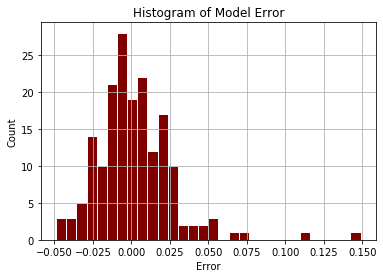

In [47]:
# EXAMPLE
plot_errors(errors)

In [31]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    
    ax.scatter(X, Y, color='black', label = Title)
    plt.legend(fontsize=15)
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(False)
    plt.xlabel("True Damage Index")
    plt.ylabel("Predicted Damage Index")
    plt.xlim(0,0.4)
    plt.ylim(0,0.4)
    #plt.title('Model Evaluation -' +  Title, fontsize = 20)
    #plt.savefig('train_SGBT_DI2.pdf', dpi=600, bbox_inches = "tight")
    plt.show()

In [90]:
# df_predictions_test_SGBT = pd.DataFrame(y_test)
# df_predictions_test_SGBT['Pred'] = pred_test
# df_predictions_test_SGBT.to_excel("DI2_predictions_test_SGBT.xlsx") 

# df_predictions_train_SGBT = pd.DataFrame(y_train)
# df_predictions_train_SGBT['Pred'] = pred_train
# df_predictions_train_SGBT.to_excel("DI2_predictions_train_SGBT.xlsx") 



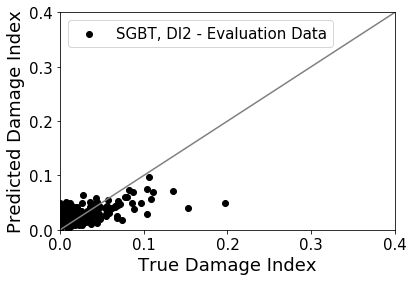

In [91]:
# EXAMPLE
plt.rcParams["figure.figsize"] = (6,4)
Title = 'SGBT, DI2 - Evaluation Data'
plot_predictions(y_test, pred_test, Title)

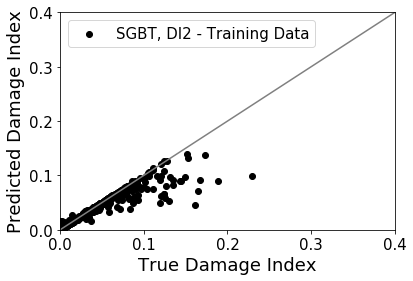

In [95]:
Title = 'SGBT, DI2 - Training Data'
plot_predictions(y_train, pred_train, Title)

In [71]:
tune_reg_3AA=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
OPT3AA=tune_reg_3AA.fit(x_train, y_train)
print(OPT3AA.score(x_test, y_test))
print(OPT3AA.score(x_train, y_train))


0.295341817761
0.756824760967


In [72]:
tune_reg_3B=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2300, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
OPT3B=tune_reg_3B.fit(x_train, y_train)
print(OPT3B.score(x_test, y_test))
print(OPT3B.score(x_train, y_train))

0.316594322789
0.8939781815


In [73]:
def prediction(model, x_train, x_test):
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)   
    return pred_train, pred_test

In [74]:
# EXAMPLE
#CHOOSE MODEL
pred_train2, pred_test2 = prediction(OPT3B, x_train, x_test)

In [75]:
# pred_train_inv_log = np.exp(pred_train2)
# pred_test_inv_log = np.exp(pred_test2)
# y_train_inv_log = np.exp(y_train)
# y_test_inv_log = np.exp(y_test)

In [117]:
def plot_predictions(y_test, pred, Title):
    df_predictions = pd.DataFrame(y_test)
    df_predictions['Pred'] = pred
    X = df_predictions.iloc[:, 0].values.reshape(-1, 1)
    Y = df_predictions.iloc[:, 1].values.reshape(-1, 1)
    fig, ax = plt.subplots()
    
    ax.scatter(X, Y, color='black', label = Title)
    plt.legend(fontsize=15)
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(False)
    plt.xlabel("True Damage Index")
    plt.ylabel("Predicted Damage Index")
    plt.xlim(0,0.4)
    plt.ylim(0,0.4)
    #plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.savefig('train_RF_DI2.pdf', dpi=600, bbox_inches = "tight")
    plt.show()

In [113]:
# df_predictions_test_RF = pd.DataFrame(y_test)
# df_predictions_test_RF['Pred'] = pred_test2
# df_predictions_test_RF.to_excel("DI2_predictions_test_RF.xlsx") 

# df_predictions_train_RF = pd.DataFrame(y_train)
# df_predictions_train_RF['Pred'] = pred_train2
# df_predictions_train_RF.to_excel("DI2_predictions_train_RF.xlsx") 

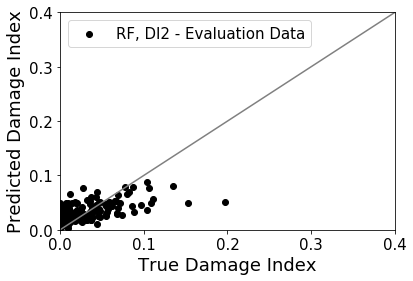

In [114]:
# EXAMPLE
plt.rcParams["figure.figsize"] = (6,4)
Title = 'RF, DI2 - Evaluation Data'
plot_predictions(y_test, pred_test2, Title)

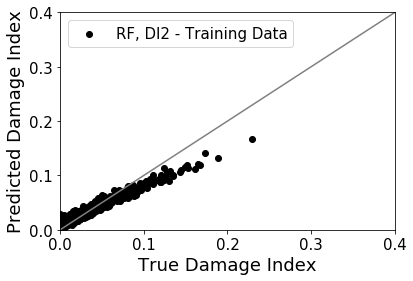

In [118]:
# EXAMPLE
plt.rcParams["figure.figsize"] = (6,4)
Title = 'RF, DI2 - Training Data'
plot_predictions(y_train, pred_train2, Title)

In [152]:
def plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title):
    df_predictions_test = pd.DataFrame(y_test)
    df_predictions_test['Pred'] = pred_test
    df_predictions_train = pd.DataFrame(y_train)
    df_predictions_train['Pred'] = pred_train   
    X1 = df_predictions_test.iloc[:, 0].values.reshape(-1, 1)
    Y1 = df_predictions_test.iloc[:, 1].values.reshape(-1, 1)
    X2 = df_predictions_train.iloc[:, 0].values.reshape(-1, 1)
    Y2 = df_predictions_train.iloc[:, 1].values.reshape(-1, 1)
    
    fig, ax = plt.subplots()
    ax.scatter(X2, Y2, color='maroon', label='Training Predictions')
    ax.scatter(X1, Y1, color='orange', label='Testing Predictions')
    
    line = mlines.Line2D([0, 1], [0, 1], color='grey')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    ax.set_xlabel(ax.get_xlabel(), fontsize = 18)
    ax.set_ylabel(ax.get_ylabel(), fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    plt.xlabel("Damage Index")
    plt.ylabel("Precited Damage Index")
    plt.xlim(0,0.25)
    plt.ylim(0,0.25)
    plt.title('Model Evaluation -' +  Title, fontsize = 20)
    plt.legend(loc='upper left')
    #plt.savefig('test_eval.png', dpi=600, bbox_inches = "tight")
    plt.show()


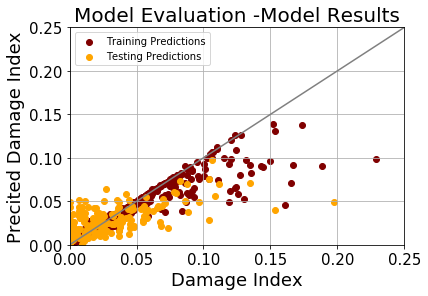

In [153]:
Title = 'Model Results'
plot_joint_predictions(y_train, pred_train, y_test, pred_test, Title)

In [154]:
def join_predictions(y_train, pred_train, y_test, pred_test, Title):
    df_predictions_test = pd.DataFrame(y_test)
    df_predictions_test['Pred'] = pred_test
    df_predictions_train = pd.DataFrame(y_train)
    df_predictions_train['Pred'] = pred_train   

    return df_predictions_test, df_predictions_train

In [156]:
df_predictions_test, df_predictions_train = join_predictions(y_train, pred_train, y_test, pred_test, Title)

In [158]:
df_predictions_test.to_excel("SGBBT_DI2_Eval.xlsx")  
df_predictions_train.to_excel("SGBBT_DI2_Train.xlsx")  

In [157]:
df_predictions_test.describe()

,y_test,Pred
count,177.000000,177.000000
mean,0.030675,0.028833
std,0.031995,0.016802
min,0.000000,0.001089
25%,0.006971,0.015484
50%,0.022069,0.026826
75%,0.044746,0.039909
max,0.197384,0.097150


In [104]:
# df_predictions_test.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/sgb_no0_testpred.xlsx")
# df_predictions_train.to_excel("/Users/lszczyrba/Documents/Research/Projects/PR_Housing/Data/sgb_no0_trainpred.xlsx")

In [22]:
# tune_reg_3B=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
#            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
#            min_impurity_split=None, min_samples_leaf=1,
#            min_samples_split=2, min_weight_fraction_leaf=0.0,
#            n_estimators=2300, n_jobs=1, oob_score=False, random_state=42,
#            verbose=0, warm_start=False)
# OPT3B=tune_reg_3B.fit(x_train, y_train)
# print(OPT3B.score(x_test, y_test))
# print(OPT3B.score(x_train, y_train))

0.316594322789
0.8939781815


In [26]:
tune_reg_2 = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=17,
                      max_features=1, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
OPT2=tune_reg_2.fit(x_train, y_train)
print(OPT2.score(x_test, y_test))
print(OPT2.score(x_train, y_train))

0.260978967575
0.892585834471


# Impurity importance

In [38]:
def calc_gini_importances(x_train, model):
    importances = model.feature_importances_
    importances_df = pd.DataFrame(importances, x_train.columns,
                                  columns=['Importance'])
    #.sort_values('Importance', ascending=False)
    importances_df.reset_index(inplace=True)
    importances_df.rename(columns={'index':'Feature'}, inplace=True)
    return importances_df


In [39]:
# indicate if reg_model or class_model
# EXAMPLE
df_gini_importances = calc_gini_importances(x_train, IDEAL3B)

In [40]:
df_gini_importances

,Feature,Importance
0,PropSFHA,0.116337
1,AveDepth,0.103923
2,PropDG,0.069472
3,AveLS,0.104842
4,HurTrack,0.128979
5,PeakGust,0.125790
6,SpecCom,0.144373
7,CDC_Tot,0.206284


In [42]:
#df_gini_importances['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']
df_gini_importances['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC','CDCVuln']

In [43]:
df_gini_importances

,Feature,Importance,Labels
0,PropSFHA,0.116337,PropSFHA
1,AveDepth,0.103923,AveDepth
2,PropDG,0.069472,PropFA
3,AveLS,0.104842,AveLS
4,HurTrack,0.128979,HurTrack
5,PeakGust,0.125790,PeakGust
6,SpecCom,0.144373,PropSC
7,CDC_Tot,0.206284,CDCVuln


In [44]:
#df_gini_importances.to_excel("RF_DI3__Dflt_FI.xlsx")

In [49]:
def plot_importance(df_gini_importances):
    df_gini_importances.sort_values('Importance', ascending=False).plot.bar('Labels',
                                                                            'Importance', 
                                                                            color='black', 
                                                                            legend = False, zorder=3)
    plt.title("", fontsize = 25)
    plt.ylabel('Mean Decrease in MSE', fontsize = 18)
    plt.xlabel('')
    plt.ylim(0,0.225)
    plt.xticks(fontsize = 18, rotation = 45, ha='right')
    plt.yticks(fontsize = 18)
    #plt.grid(True)
    plt.savefig('RF_DI2__Dflt_FI_NOSOVISTRVI.pdf', dpi=600, bbox_inches = "tight")
    


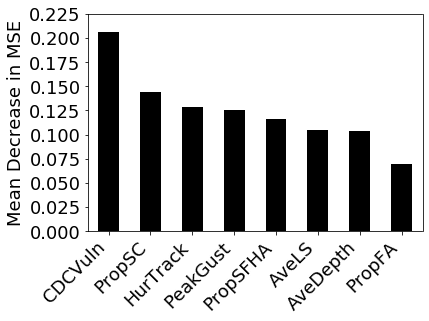

In [50]:
# EXAMPLE
# these values are Normalized Average Decrease In Total MSE
plot_importance(df_gini_importances)

# Permutation Importance

In [51]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'CDC_Tot'],
      dtype='object')

In [53]:
IDEAL3B.score(x_train,y_train)

0.85972811045992248

In [54]:
def calc_permutation_imp(model,x,y, features):
    baseline = model.score(x,y)
    imp = []
    for col in x.columns:
        save = x[col].copy()
        x[col]=np.random.permutation(x[col])
        m = model.score(x,y)
        x[col] = save
        imp.append(((baseline - m)/baseline)*100)
        
    Results = np.array(imp)
    Results = pd.DataFrame(Results)
    Results['Feature'] = features
    Results.rename(columns = {0:'Importance'}, inplace=True)
    
    return Results

In [55]:
# features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
#        'PeakGust', 'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot']
features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack',
       'PeakGust', 'SpecCom',  'CDC_Tot']
df_perm_imp = calc_permutation_imp(IDEAL3B,x_train,y_train, features)

In [56]:
#df_perm_imp.Importance.sum()

In [57]:
df_perm_imp

,Importance,Feature
0,10.675858,PropSFHA
1,17.923077,AveDepth
2,6.464478,PropDG
3,18.496582,AveLS
4,22.626190,HurTrack
5,29.997445,PeakGust
6,39.040536,SpecCom
7,35.772670,CDC_Tot


In [58]:
#df_perm_imp['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']
df_perm_imp['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC','CDCVuln']


In [59]:
df_perm_imp

,Importance,Feature,Labels
0,10.675858,PropSFHA,PropSFHA
1,17.923077,AveDepth,AveDepth
2,6.464478,PropDG,PropFA
3,18.496582,AveLS,AveLS
4,22.626190,HurTrack,HurTrack
5,29.997445,PeakGust,PeakGust
6,39.040536,SpecCom,PropSC
7,35.772670,CDC_Tot,CDCVuln


In [76]:
#df_perm_imp.to_excel("RF_DI3__Perm_FI.xlsx")

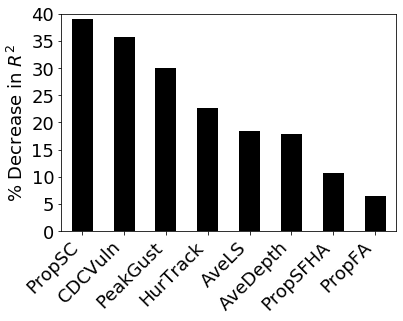

In [62]:
df_perm_imp.sort_values('Importance', ascending=False).plot.bar('Labels',
                                                                            'Importance', 
                                                                            color='black', 
                                                                            legend = False, zorder=3)
plt.title("", fontsize = 25)
plt.ylabel('% Decrease in ' + r'$R^2$', fontsize = 18)
plt.xlabel('')
plt.xticks(fontsize = 18, rotation = 45, ha='right')
plt.yticks(fontsize = 18)
plt.ylim(0,40)
#plt.grid(True)
plt.savefig('SGBT_DI2_Perm_FI_NOSOVISTRVI.pdf', dpi=600, bbox_inches = "tight")

In [234]:
# ## Y LABLEL SHOULD BE Percent DECREASE IN R^2
# plot_importance(df_perm_imp)

In [125]:
# def calc_permutation_imp(model,x,y,features):
#     baseline = model.score(x,y)
#     imp = []
#     features = features
#     for col in features:
#         save = x.copy()
#         x[col]=np.random.permutation(x[col])
#         m = model.score(x,y)
#         x[col] = save
#         imp.append(baseline - m)
#     Results = np.array(imp)
#     Results = pd.DataFrame(Results)
#     Results['Feature'] = features
#     Results.rename(columns = {0:'Importance'}, inplace=True)
#     return Results

In [126]:
# features = ['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
#        'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'] 
# df_perm_imp = calc_permutation_imp(IDEAL4,x_train,y_train,features)

In [127]:
# plot_importance(df_perm_imp)

### Group Permutation Importance

In [63]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'CDC_Tot'],
      dtype='object')

In [64]:
# features = [['PeakGust', 'HurTrack'],
#            ['STRVI_1', 'SpecCom', 'SEVI_1', 'CDC_Tot'],
#            ['AveDepth', 'PropDG', 'PropSFHA'],
#            ['AveLS']]

features = [['PeakGust', 'HurTrack'],
           ['SpecCom','CDC_Tot'],
           ['AveDepth', 'PropDG', 'PropSFHA'],
           ['AveLS']]

In [65]:
I = importances(IDEAL3B, x_train,y_train, features=features)

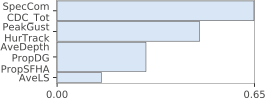

In [66]:
plot_importances(I)

In [67]:
I.reset_index(inplace=True)
I.drop(['Feature'], axis=1)
I['Feature'] = ['Vulnerability', 'Wind', 'Flood', 'Landslide']

In [68]:
I

,Feature,Importance
0,Vulnerability,0.644575
1,Wind,0.467134
2,Flood,0.291024
3,Landslide,0.145680


In [69]:
base_score = IDEAL3B.score(x_train, y_train)

In [70]:
I['basescore'] = base_score

In [71]:
I

,Feature,Importance,basescore
0,Vulnerability,0.644575,0.859728
1,Wind,0.467134,0.859728
2,Flood,0.291024,0.859728
3,Landslide,0.145680,0.859728


In [72]:
I['Perc_Dec'] = ((I['Importance']) / I['basescore']) * 100

In [73]:
I

,Feature,Importance,basescore,Perc_Dec
0,Vulnerability,0.644575,0.859728,74.974298
1,Wind,0.467134,0.859728,54.335027
2,Flood,0.291024,0.859728,33.850683
3,Landslide,0.145680,0.859728,16.944846


In [74]:
#I.to_excel("RF_DI3__GroupPerm_FI.xlsx")

In [75]:
#I.Importance.sum()

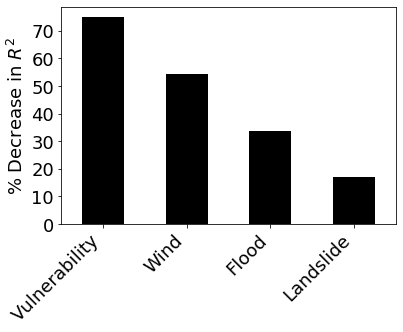

In [77]:
I.sort_values('Perc_Dec', ascending=False).plot.bar('Feature',
                                                                            'Perc_Dec', 
                                                                            color='black', 
                                                                            legend = False, zorder=3)
plt.title("", fontsize = 25)
plt.ylabel('% Decrease in ' + r'$R^2$', fontsize = 18)
plt.xlabel('')
plt.xticks(fontsize = 18, rotation = 45, ha='right')
#plt.xticks(np.arange(min(0), max(100), 20))
plt.yticks(fontsize = 18)
#plt.grid(True)
plt.savefig('SGBT_DI2_GroupPerm_FI_NOSOVISTRVI.pdf', dpi=600, bbox_inches = "tight")

In [68]:
#plot_importance(I)

# Partial Dependence

In [89]:
x_train.columns

Index(['PropSFHA', 'AveDepth', 'PropDG', 'AveLS', 'HurTrack', 'PeakGust',
       'SpecCom', 'STRVI_1', 'SEVI_1', 'CDC_Tot'],
      dtype='object')

In [90]:
#df_perm_imp['Labels'] = ['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']

In [91]:
plt.rcParams.update({'font.size': 12})

In [98]:
def plot_part_depend(model, x_train, feature_list, feature_names):
    with plt.rc_context({'legend.fontsize': 'large',
              'figure.figsize': (20, 20),
             'axes.labelsize': 'large',
             'axes.titlesize':'large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}):
        #plt.subplots(nrows=3,ncols=3, sharey=True)
        plot_partial_dependence(model, 
                                x_train, 
                                feature_list, 
                                feature_names = feature_names, 
                                grid_resolution=10, 
                                n_cols=4,
                                method='brute', line_kw={"c": "black"}
                               ) 
        fig = plt.gcf()
        #fig.suptitle('test title', fontsize=20, y = .75)
        fig.subplots_adjust(hspace=0.3)
        #ax.set_ylabel('common ylabel')
        #fig.axes.get_yaxis().set_visible(False)
        #fig.subplots_adjust(sharey='row')
        #fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
        #plt.savefig('SGBT_DI2_PDP_BW.pdf', dpi=600, bbox_inches = "tight")


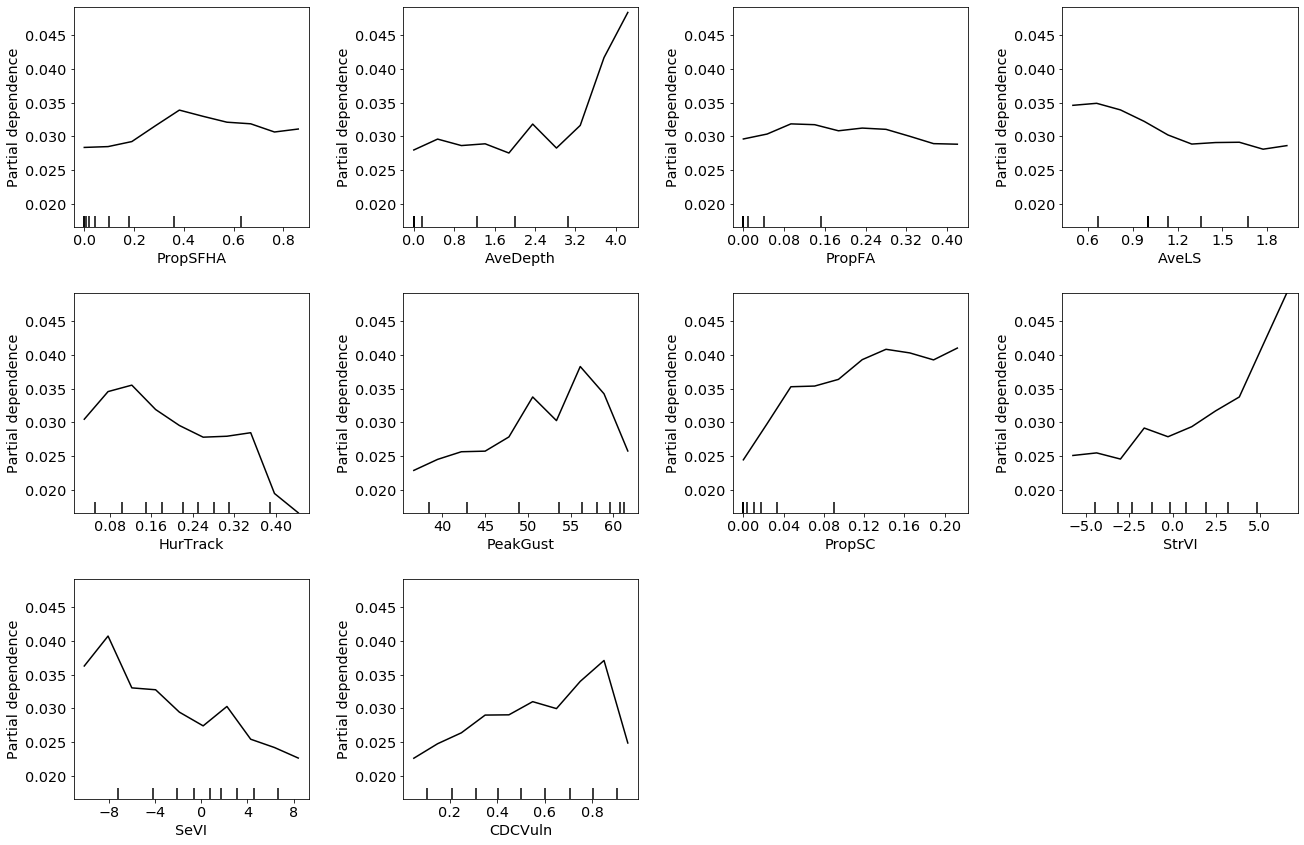

In [99]:
#EXAMPLE
feature_list=[0,1,2,3,4,5,6,7,8,9]
feature_names=['PropSFHA', 'AveDepth', 'PropFA', 'AveLS', 'HurTrack', 'PeakGust', 'PropSC', 'StrVI', 'SeVI', 'CDCVuln']
plot_part_depend(IDEAL3B, x_train, feature_list, feature_names)

In [73]:
# plt.rcParams["figure.figsize"] = (10,10)
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'large',
#          'ytick.labelsize':'large'}
# plt.rcParams.update(params)


# #plt.subplots(nrows=3,ncols=3, sharey=True)
# fig = plot_partial_dependence(IDEAL1, 
#                         x_train, 
#                         [0,1,2,3,4,5,6,7,8,9,10,11,12,13], 
#                         feature_names =['PropSFHA', 'AveDepth', 'PropDG', 'MaxDepth', 'AveLS', 'HurTrack',
#                            'PeakGust', 'MaxSusta', 'SpecCom', 'STRVI_1', 'SEVI_1', 'STR_SEVI_1',
#                            'SOVI_1', 'CDC_Tot'], 
#                         grid_resolution=10, 
#                         #n_cols=2
#                        ) 

# plt.tight_layout(h_pad=3,w_pad=1)

# plt.savefig('partialdependence.png', dpi=400, bbox_inches = "tight")



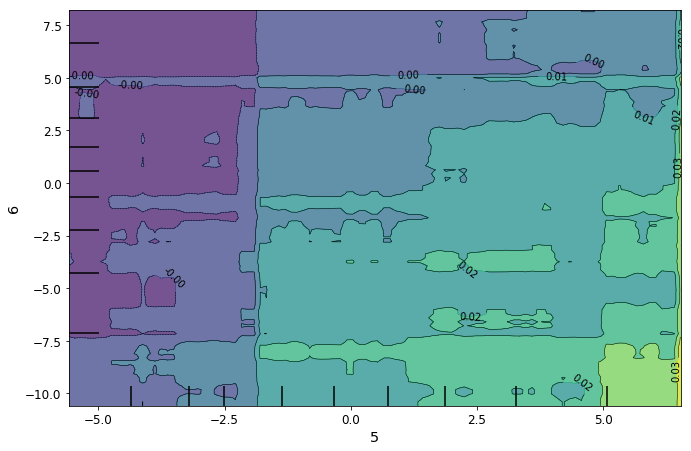

In [90]:
fig = plot_partial_dependence(IDEAL2, x_train, [(5,6)]) 

In [29]:
from pycebox.ice import ice, ice_plot

In [31]:
forty_ice_df = ice(data=x_train, column='HurTrack', 
                   predict=IDEAL2.predict)

In [33]:
cmap2 = plt.get_cmap('OrRd')

In [44]:
wt_vals = forty_ice_df.columns.get_level_values('PeakGust').values
sm = plt.cm.ScalarMappable(cmap=cmap2, 
                           norm=plt.Normalize(vmin=wt_vals.min(), 
                                              vmax=wt_vals.max()))
sm._A = []

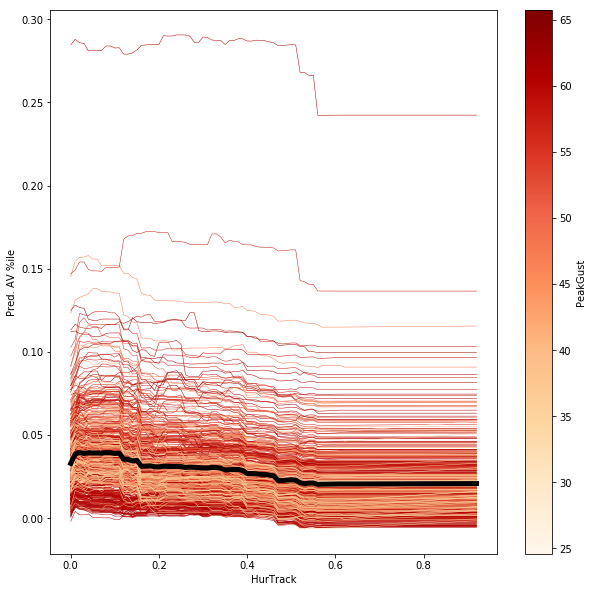

In [47]:
ice_plot(forty_ice_df, linewidth=.5, color_by='PeakGust', cmap=cmap2, plot_pdp=True, 
         pdp_kwargs={'c': 'k', 'linewidth': 5})
plt.colorbar(sm, label='PeakGust')
plt.ylabel('Pred. AV %ile')
plt.xlabel('HurTrack');

In [153]:
def calc_permutation_importance(criterion, model, df_x, y):
    features = df_x.columns.values
    X = df_x.as_matrix()
    Y = y.as_matrix()
    scores = defaultdict(list)
    rf = model
    for train_idx, test_idx in ShuffleSplit(len(X), 100, .3, random_state=42): #number of splits, absolute number of test samples, proportion of data in train split
        X_train, X_test = X[train_idx], X[test_idx] #Random permutation cross-validator, Yields indices to split data into training and test sets.
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = rf.fit(X_train, Y_train)
        acc = criterion(Y_test, rf.predict(X_test))
        for i in range(X.shape[1]): #The shape attribute for numpy arrays returns the dimensions of the array. If Y has n rows and m columns, then Y.shape is (n,m). So Y.shape[0] is n.
            X_t = X_test.copy()
            np.random.seed(42)
            np.random.shuffle(X_t[:, i]) #rearranging randomly
            shuff_acc = criterion(Y_test, rf.predict(X_t)) 
            scores[features[i]].append((acc-shuff_acc)/acc) #change in importance, actual - shuffled/actual, this is percent error        
    mda_features = [f for f in scores.keys()]
    mda_importance = [(np.mean(score)) for score in scores.values()] #average over all the shuffled permutations
    mda_indices = np.argsort(mda_importance)
    return mda_features, mda_importance, mda_indices

In [154]:
#EXAMPLE
#criterion can be r2_score or mean_squared_error
#should be MSE i think

criterion = r2_score
mda_features, mda_importance, mda_indices = calc_permutation_importance(criterion, IDEAL4, x_train, y_train)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


TypeError: 'ShuffleSplit' object is not iterable

In [104]:
# def permutation_importance_plot(mda_features, mda_importance):
#     df_perm_FI = pd.DataFrame({'Feature':mda_features, 'Importance':[abs(number) for number in mda_importance]})
#     df_perm_FI.sort_values('Importance', ascending=False).plot.bar('Feature',
#                                                                    'Importance', 
#                                                                     color='maroon', 
#                                                                     legend = False)
#     plt.title("Feature Importances", fontsize = 30)
#     plt.ylabel('Importance')
#     plt.xlabel('')
#     plt.xticks(fontsize = 12, rotation = 45, ha='right')
#     plt.savefig('permutimportance.png', dpi=600, bbox_inches = "tight")

In [105]:
# # EXAMPLE
# permutation_importance_plot(mda_features, mda_importance)

In [146]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

In [143]:
hi = GradientBoostingRegressor(loss = 'lad',
                                learning_rate=0.08,
                                max_depth = 12,
                                max_features=5,
                                min_samples_leaf= 4,
                                min_samples_split=16,
                                n_estimators=95,
                                subsample = 0.8)

In [144]:
OPT4 = hi.fit(x_train, y_train)

In [145]:
imp = permutation_importances(OPT4, x_train, y_train, oob_regression_r2_score)


AttributeError: 'numpy.ndarray' object has no attribute 'random_state'

In [ ]:
impcopy = imp.copy()

In [87]:
def perm_imp_plot(importances):
    importances.reset_index(inplace=True)
    importances.sort_values('Importance', ascending=False).plot.bar('Feature',
                                                                            'Importance', 
                                                                            color='maroon', 
                                                                            legend = False)
    plt.title("Feature Importances", fontsize = 25)
    plt.ylabel('Importance', fontsize = 16)
    plt.xlabel('')
    plt.xticks(fontsize = 16, rotation = 45, ha='right')
    plt.yticks(fontsize = 14)
#     plt.savefig('giniimportance.png', dpi=600, bbox_inches = "tight")

AttributeError: 'numpy.ndarray' object has no attribute 'random_state'

In [ ]:
perm_imp_plot(imp)